### **Hand Gesture Processing and Analysis**  

This project extracts and analyses hand landmark coordinates from images to understand gesture variations. It uses **OpenCV, MediaPipe, Pandas, NumPy, and Matplotlib** for image processing, data handling, and visualisation. A custom **HandDetector** extracts and processes hand landmarks.

Images are read, landmarks detected, and **relative coordinates** (based on the wrist) are extracted. The data is saved in **CSV files** for each gesture, with a **combined dataset** for all gestures. Statistical analysis and **x, y, z** coordinate distributions are visualised to compare variations across gestures.

Applied to the **ASL Alphabet Dataset**, this structured approach enables sign language letter recognition.


In [13]:
# Importing libraries
import cv2
import mediapipe as mp
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from hand_detection import HandDetector

### **Processing a Single Image**  

This function detects hand landmarks using **MediaPipe**, extracts **relative coordinates** using the wrist as the base point, and returns them as coordinates. If `visualize=True`, it displays the image with landmarks.


In [15]:
detector = HandDetector(static_image_mode=True)

def process_single_image(image_path, label, visualize=False):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return []
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = detector.hands.process(image_rgb)
    
    coordinates = []
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get raw coordinates
            coords = detector.get_relative_coordinates(hand_landmarks, image.shape[1], image.shape[0])
            
            # Get wrist coordinates (point 0 is the wrist in MediaPipe)
            wrist_x, wrist_y, wrist_z = coords[0]
            
            # Calculate coordinates relative to wrist
            relative_coords = []
            for coord in coords:
                relative_coords.append([
                    coord[0] - wrist_x,  # x relative to wrist
                    coord[1] - wrist_y,  # y relative to wrist
                    coord[2] - wrist_z   # z relative to wrist
                ])
            
            # Store only relative coordinates
            for i, coord in enumerate(relative_coords):
                coordinates.append({
                    'image': os.path.basename(image_path),
                    'label': label,
                    'hand_point': i,
                    'x': coord[0],
                    'y': coord[1],
                    'z': coord[2]
                })
            
            if visualize:
                # Draw landmarks on the image
                mp.solutions.drawing_utils.draw_landmarks(
                    image_rgb,
                    hand_landmarks,
                    mp.solutions.hands.HAND_CONNECTIONS
                )
                plt.figure(figsize=(10, 10))
                plt.imshow(image_rgb)
                plt.title(f'Gesture Label: {label}')
                plt.axis('off')
                plt.show()
    
    return coordinates

### **Processing a Folder of Sign Lanuage Letters**  

This function scans a **base folder** containing subfolders of sign lanuage letters, processes all images to extract hand landmark coordinates, and saves them as **CSV files**.  

It creates a **combined dataset** to support real-time translation of fingerspelling into digital text, displaying the signed letter along with confidence levels. If no hands are detected, it returns an empty result.  

          Args:
    #     base_folder (str): Path to the base folder containing gesture subfolders
    #     output_folder (str): Path to output folder where CSV files will be saved


In [16]:
def process_folder(base_folder, output_folder):

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Dictionary to store DataFrames for each gesture
    gesture_data = {}
    
    # Get all subfolders (each represents a gesture class)
    gesture_folders = [f.path for f in os.scandir(base_folder) if f.is_dir()]
    
    for gesture_folder in gesture_folders:
        gesture_label = os.path.basename(gesture_folder)
        print(f"Processing gesture: {gesture_label}")
        
        # Process all images in the gesture folder
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            image_files.extend(glob(os.path.join(gesture_folder, ext)))
        
        gesture_coordinates = []
        for img_path in image_files:
            coords = process_single_image(img_path, gesture_label)
            gesture_coordinates.extend(coords)
        
        if gesture_coordinates:
            # Create DataFrame for this gesture
            df = pd.DataFrame(gesture_coordinates)
            
            # Save to CSV
            csv_path = os.path.join(output_folder, f"{gesture_label}.csv")
            df.to_csv(csv_path, index=False)
            print(f"Saved {gesture_label} coordinates to {csv_path}")
            print(f"Total images processed for {gesture_label}: {df['image'].nunique()}")
            
            # Store DataFrame in dictionary
            gesture_data[gesture_label] = df
        else:
            print(f"No hands detected in {gesture_label} images")
    
    # Create a combined CSV with all gestures
    if gesture_data:
        combined_df = pd.concat(gesture_data.values(), ignore_index=True)
        combined_csv_path = os.path.join(output_folder, "all_gestures.csv")
        combined_df.to_csv(combined_csv_path, index=False)
        print(f"\nSaved combined data to {combined_csv_path}")
        print(f"Total gestures processed: {len(gesture_data)}")
        print(f"Total images processed: {combined_df['image'].nunique()}")
        return gesture_data, combined_df
    else:
        print("No hands detected in any images")
        return None, None

### **Analysing Hand Coordinates**  

This function computes statistics and visualises **x, y, z** distributions for sign lanuage letters. 

It summarises the dataset, processes images, and plots histograms to compare coordinate variations, aiding real-time sign recognition.  


In [17]:
def analyze_coordinates(gesture_data, combined_df=None):

    if not gesture_data:
        print("No data to analyze")
        return
    
    # Overall statistics
    print("Dataset Summary:")
    print(f"Number of gesture classes: {len(gesture_data)}")
    
    # Per-gesture statistics
    print("\nGesture Statistics:")
    for label, df in gesture_data.items():
        print(f"\nGesture: {label}")
        print(f"Number of images: {df['image'].nunique()}")
        print(f"Number of points: {len(df)}")
        
        # Plot coordinate distributions for this gesture
        plt.figure(figsize=(15, 5))
        for coord in ['x', 'y', 'z']:
            plt.subplot(1, 3, ['x', 'y', 'z'].index(coord) + 1)
            plt.hist(df[coord], bins=30)
            plt.title(f'{coord} Distribution - {label}')
            plt.xlabel(f'{coord} coordinate')
            plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
        # Basic statistics
        print("\nCoordinate Statistics:")
        print(df[['x', 'y', 'z']].describe())
    
    # Combined analysis if available
    if combined_df is not None:
        print("\nCombined Dataset Analysis:")
        # Plot coordinate distributions by gesture
        for coord in ['x', 'y', 'z']:
            plt.figure(figsize=(15, 5))
            for label in combined_df['label'].unique():
                label_data = combined_df[combined_df['label'] == label]
                plt.hist(label_data[coord], alpha=0.5, label=label, bins=30)
            plt.title(f'{coord} Distribution by Gesture')
            plt.xlabel(f'{coord} coordinate')
            plt.ylabel('Count')
            plt.legend()
            plt.show()

In [18]:
# Example usage
# base_folder = "path/to/gesture/folders"  # Should contain subfolders for each gesture
# output_folder = "output/coordinates"  # Folder where CSV files will be saved
# 
# # Process images
# gesture_data, combined_df = process_folder(base_folder, output_folder)
# 
# # Analyze results
# if gesture_data:
#     analyze_coordinates(gesture_data, combined_df)

Processing gesture: A
Saved A coordinates to ASL_Alphabet_Dataset/asl_alphabet_train/output_coordinates\A.csv
Total images processed for A: 5279
Processing gesture: B
Saved B coordinates to ASL_Alphabet_Dataset/asl_alphabet_train/output_coordinates\B.csv
Total images processed for B: 6007
Processing gesture: C
Saved C coordinates to ASL_Alphabet_Dataset/asl_alphabet_train/output_coordinates\C.csv
Total images processed for C: 4880
Processing gesture: D
Saved D coordinates to ASL_Alphabet_Dataset/asl_alphabet_train/output_coordinates\D.csv
Total images processed for D: 5973
Processing gesture: del
Saved del coordinates to ASL_Alphabet_Dataset/asl_alphabet_train/output_coordinates\del.csv
Total images processed for del: 3553
Processing gesture: E
Saved E coordinates to ASL_Alphabet_Dataset/asl_alphabet_train/output_coordinates\E.csv
Total images processed for E: 5417
Processing gesture: F
Saved F coordinates to ASL_Alphabet_Dataset/asl_alphabet_train/output_coordinates\F.csv
Total images

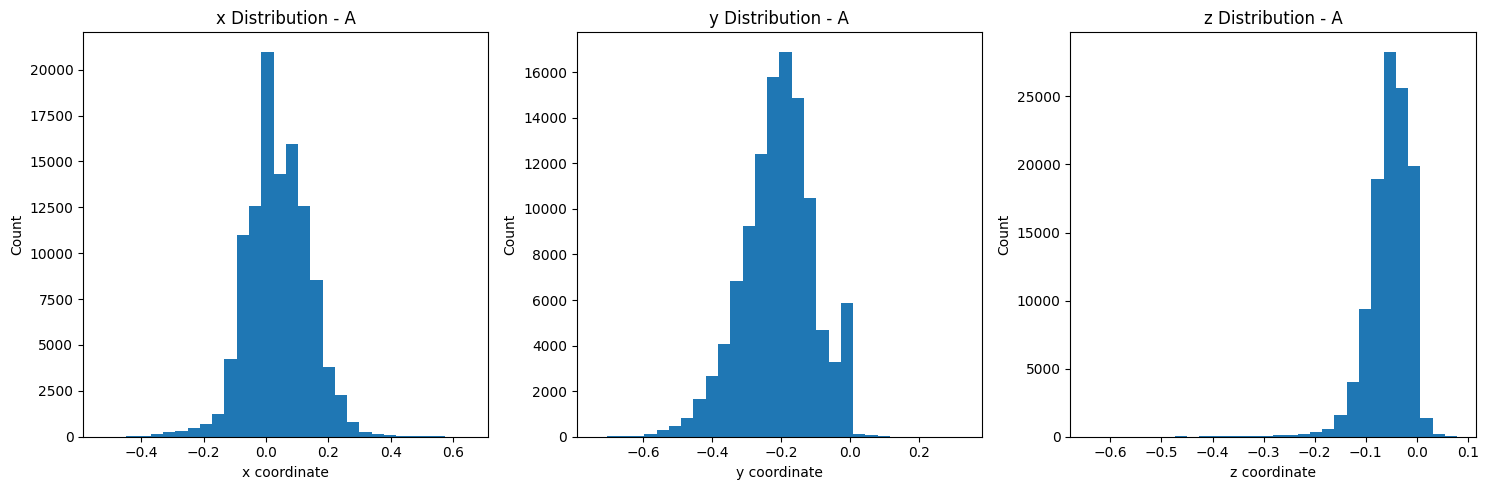


Coordinate Statistics:
                   x              y              z
count  110859.000000  110859.000000  110859.000000
mean        0.038811      -0.208139      -0.052188
std         0.099481       0.105284       0.042093
min        -0.526371      -0.738726      -0.642412
25%        -0.025165      -0.271519      -0.073254
50%         0.035668      -0.203186      -0.047920
75%         0.104735      -0.142578      -0.023877
max         0.653331       0.328576       0.079320

Gesture: B
Number of images: 6007
Number of points: 126168


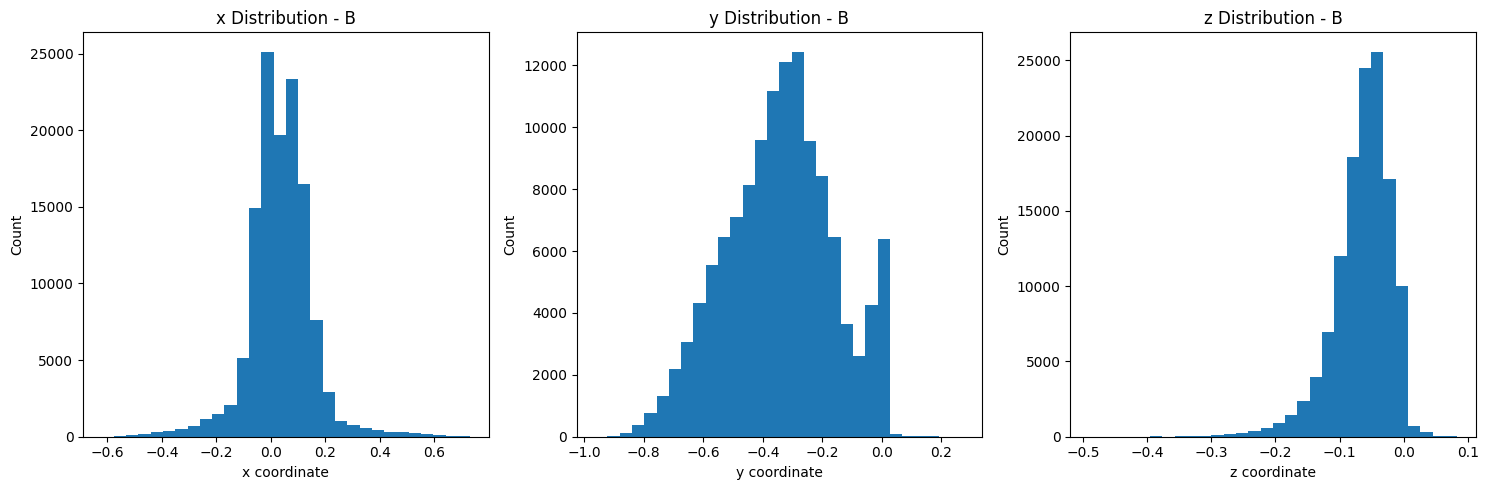


Coordinate Statistics:
                   x              y              z
count  126168.000000  126168.000000  126168.000000
mean        0.036277      -0.341154      -0.064442
std         0.117411       0.183238       0.045708
min        -0.620881      -0.963470      -0.491309
25%        -0.023469      -0.466798      -0.086261
50%         0.035507      -0.334264      -0.057723
75%         0.098975      -0.219114      -0.034262
max         0.730553       0.274454       0.083394

Gesture: C
Number of images: 4880
Number of points: 104349


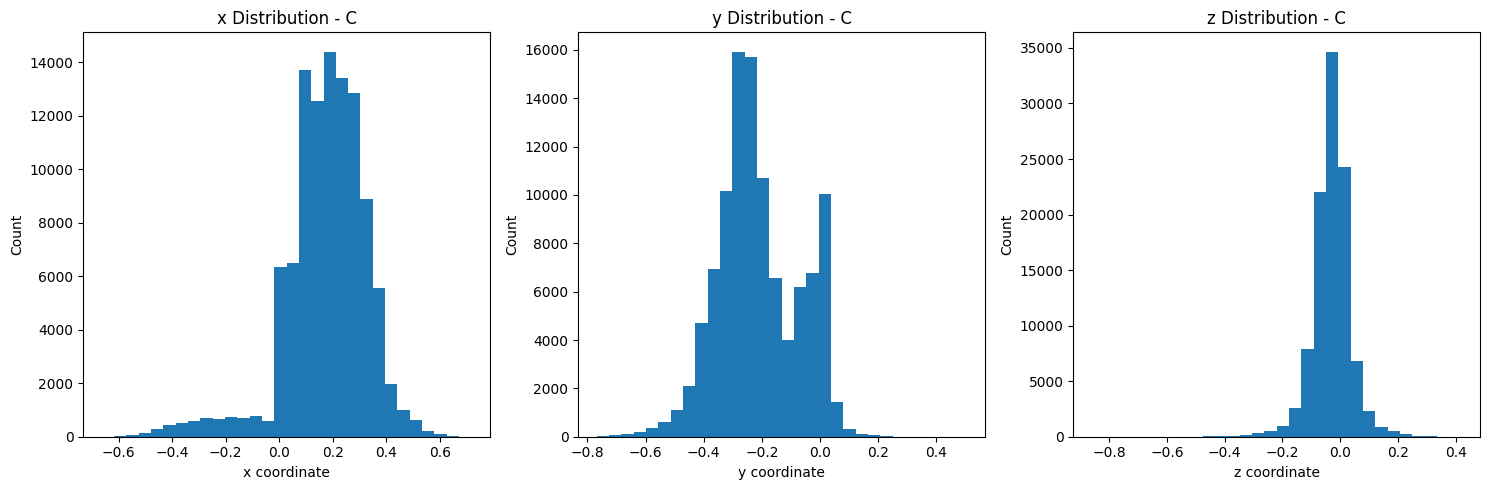


Coordinate Statistics:
                   x              y              z
count  104349.000000  104349.000000  104349.000000
mean        0.174950      -0.212486      -0.030401
std         0.153715       0.139547       0.064613
min        -0.663242      -0.768252      -0.860273
25%         0.098554      -0.302944      -0.061642
50%         0.187497      -0.234627      -0.028896
75%         0.277237      -0.101118       0.000000
max         0.718621       0.503469       0.419847

Gesture: D
Number of images: 5973
Number of points: 125496


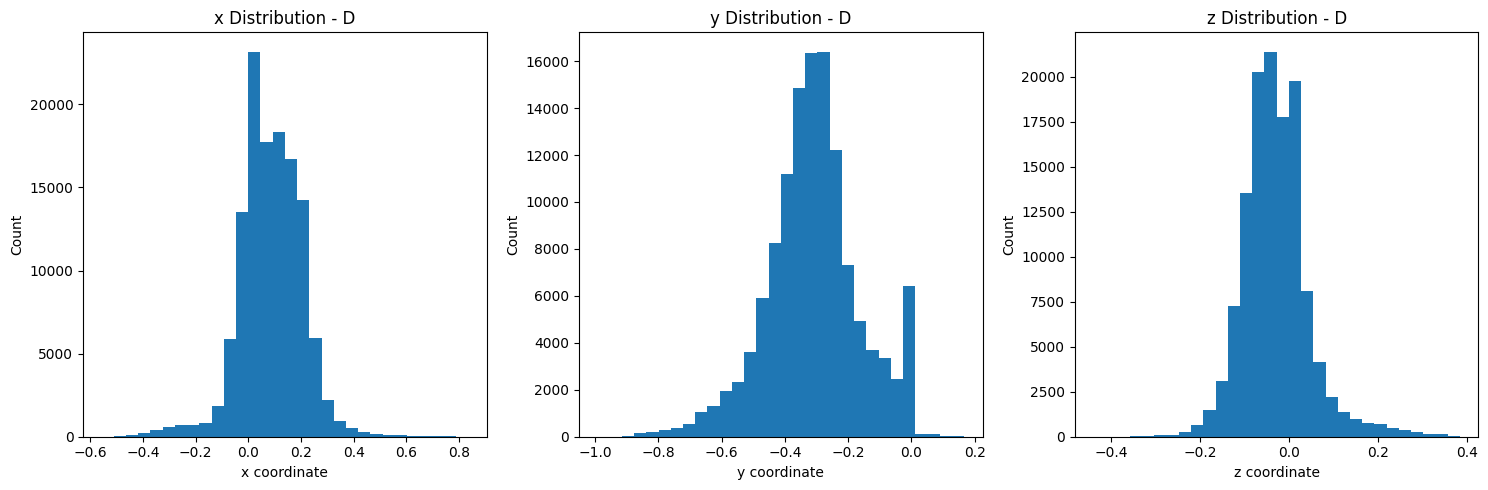


Coordinate Statistics:
                   x              y              z
count  125496.000000  125496.000000  125496.000000
mean        0.085152      -0.309148      -0.030492
std         0.120129       0.149311       0.074686
min        -0.556784      -0.992920      -0.440524
25%         0.001400      -0.393603      -0.075615
50%         0.085742      -0.310566      -0.035921
75%         0.166918      -0.230898       0.002798
max         0.834502       0.166903       0.383518

Gesture: del
Number of images: 3553
Number of points: 75201


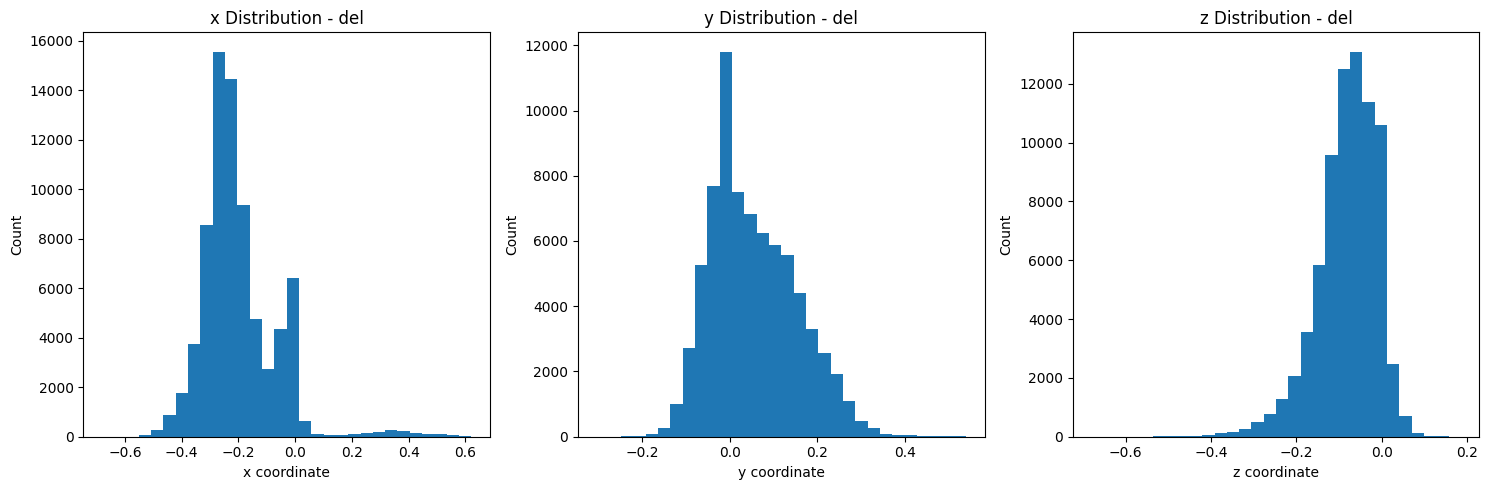


Coordinate Statistics:
                  x             y             z
count  75201.000000  75201.000000  75201.000000
mean      -0.199575      0.055006     -0.080589
std        0.133442      0.098003      0.071015
min       -0.681600     -0.303502     -0.680663
25%       -0.279416     -0.016572     -0.118034
50%       -0.227862      0.038299     -0.072527
75%       -0.148036      0.122683     -0.030037
max        0.621225      0.539237      0.185624

Gesture: E
Number of images: 5417
Number of points: 113946


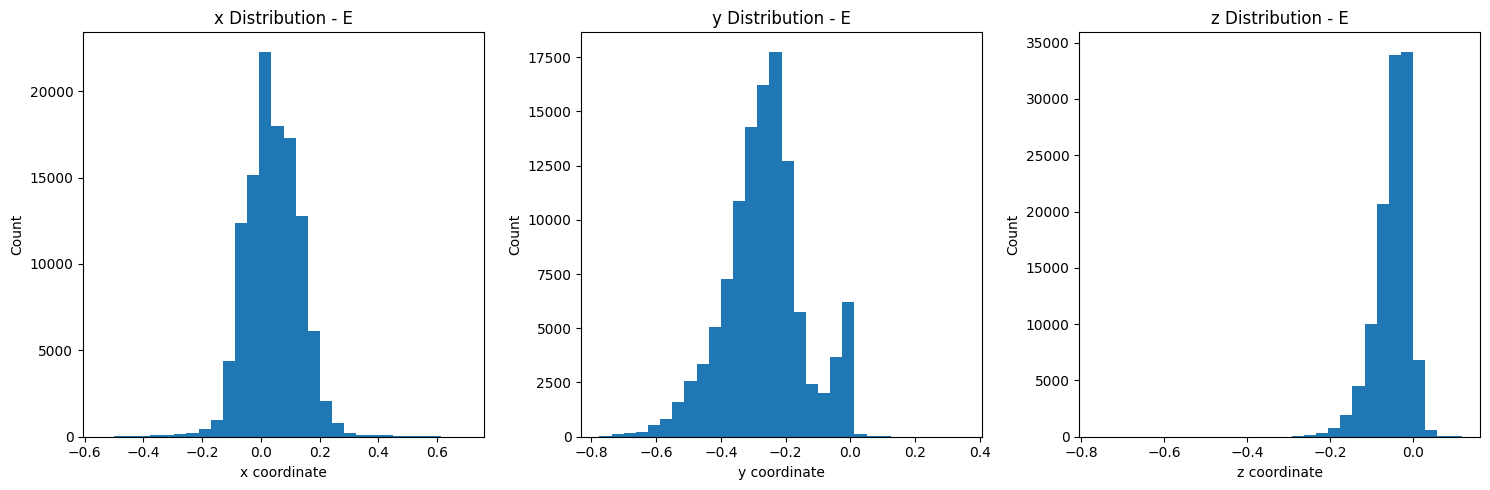


Coordinate Statistics:
                   x              y              z
count  113946.000000  113946.000000  113946.000000
mean        0.040202      -0.266050      -0.047038
std         0.091122       0.126208       0.042848
min        -0.542895      -0.775376      -0.761152
25%        -0.019850      -0.337221      -0.068722
50%         0.037506      -0.265801      -0.040296
75%         0.103409      -0.202056      -0.017095
max         0.696796       0.350109       0.118754

Gesture: F
Number of images: 7484
Number of points: 157815


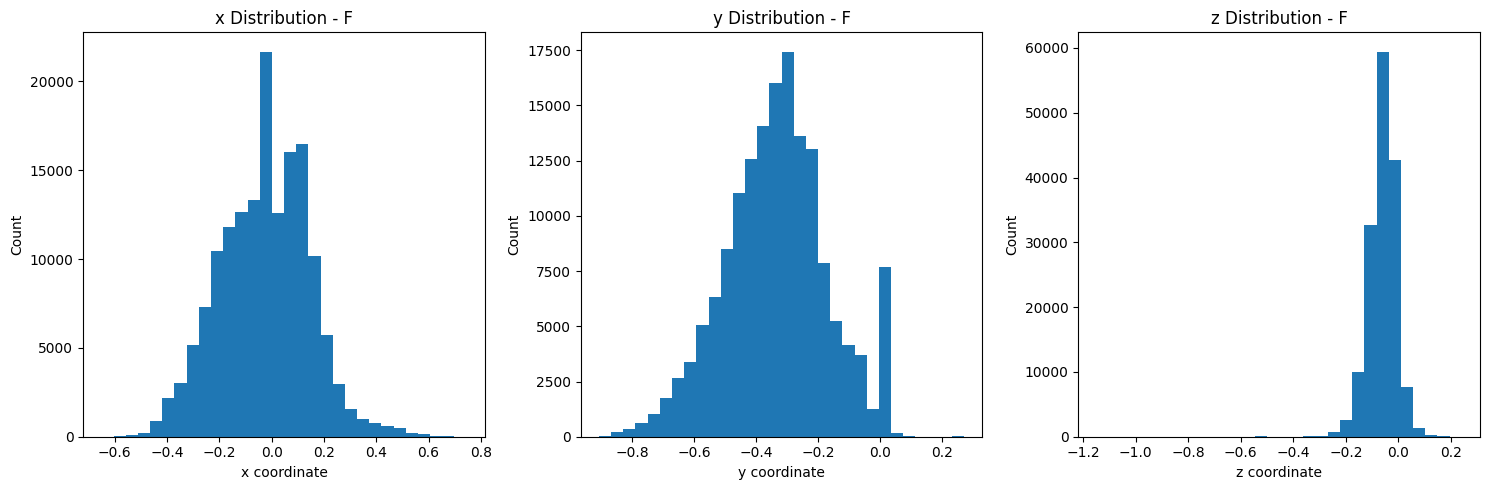


Coordinate Statistics:
                   x              y              z
count  157815.000000  157815.000000  157815.000000
mean       -0.023917      -0.334139      -0.061263
std         0.171002       0.166460       0.060354
min        -0.650533      -0.908180      -1.149618
25%        -0.144706      -0.441970      -0.089765
50%        -0.007887      -0.329617      -0.058270
75%         0.096440      -0.229106      -0.025344
max         0.745385       0.270250       0.241420

Gesture: G
Number of images: 6035
Number of points: 126903


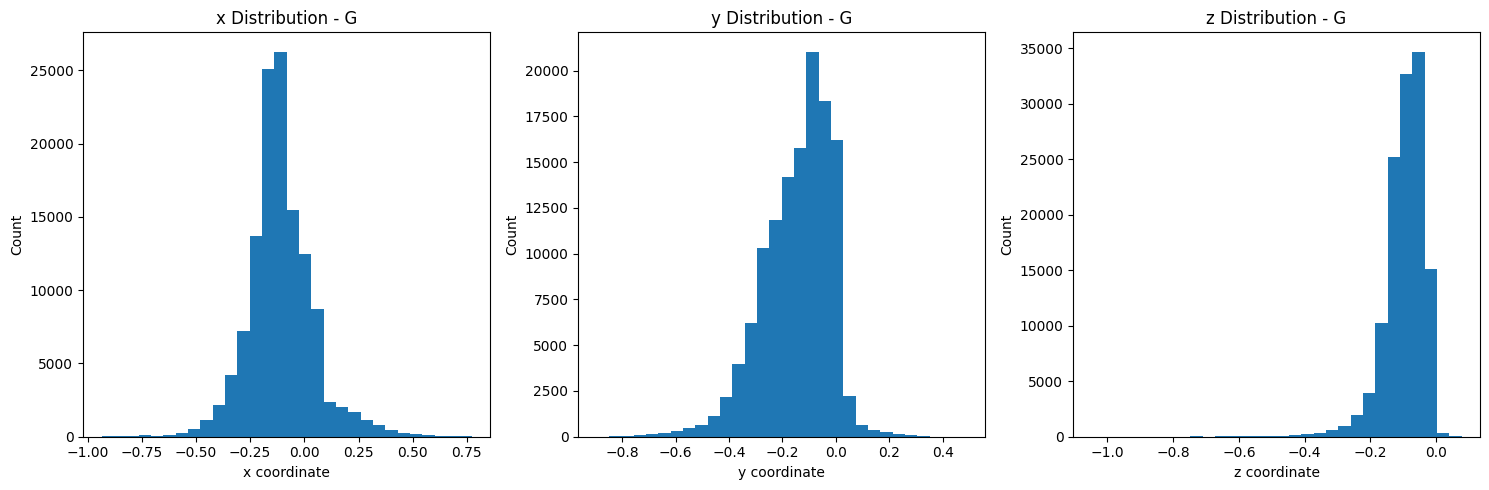


Coordinate Statistics:
                   x              y              z
count  126903.000000  126903.000000  126903.000000
mean       -0.109694      -0.144150      -0.096593
std         0.153461       0.129230       0.066444
min        -0.934809      -0.895641      -1.048180
25%        -0.190471      -0.225402      -0.126665
50%        -0.121888      -0.121307      -0.087623
75%        -0.034166      -0.050088      -0.055098
max         0.771110       0.489347       0.077085

Gesture: H
Number of images: 5885
Number of points: 124194


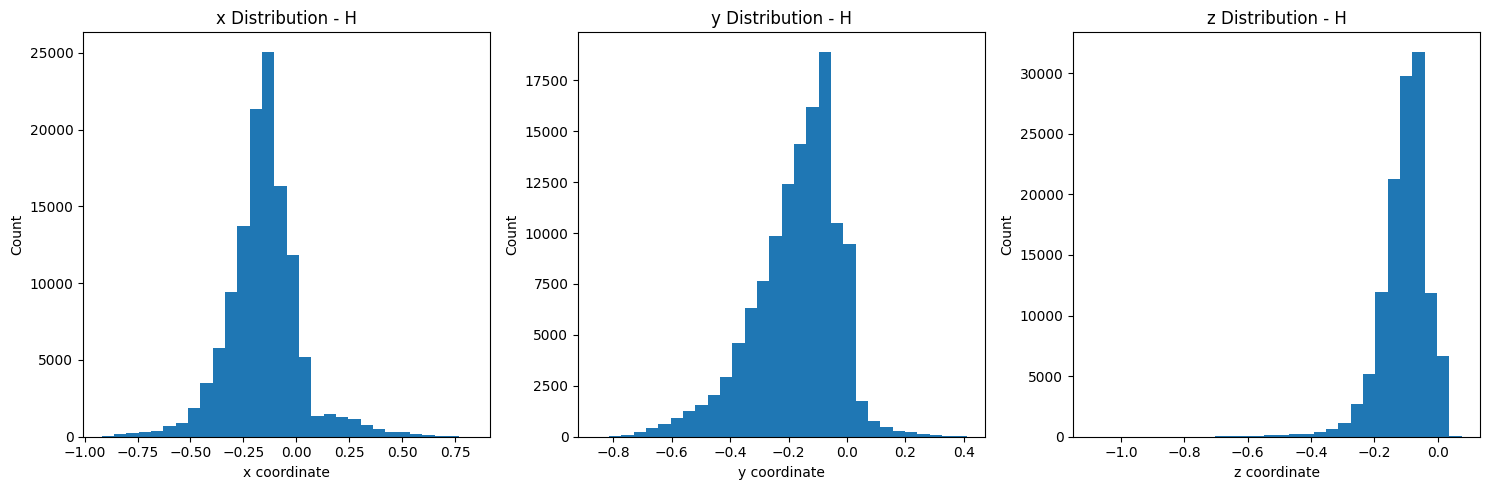


Coordinate Statistics:
                   x              y              z
count  124194.000000  124194.000000  124194.000000
mean       -0.154601      -0.173875      -0.106489
std         0.172069       0.147143       0.074675
min        -0.919293      -0.856528      -1.092477
25%        -0.244614      -0.255696      -0.141929
50%        -0.153395      -0.148367      -0.094363
75%        -0.075531      -0.071974      -0.057944
max         0.826420       0.408812       0.075035

Gesture: I
Number of images: 5719
Number of points: 120120


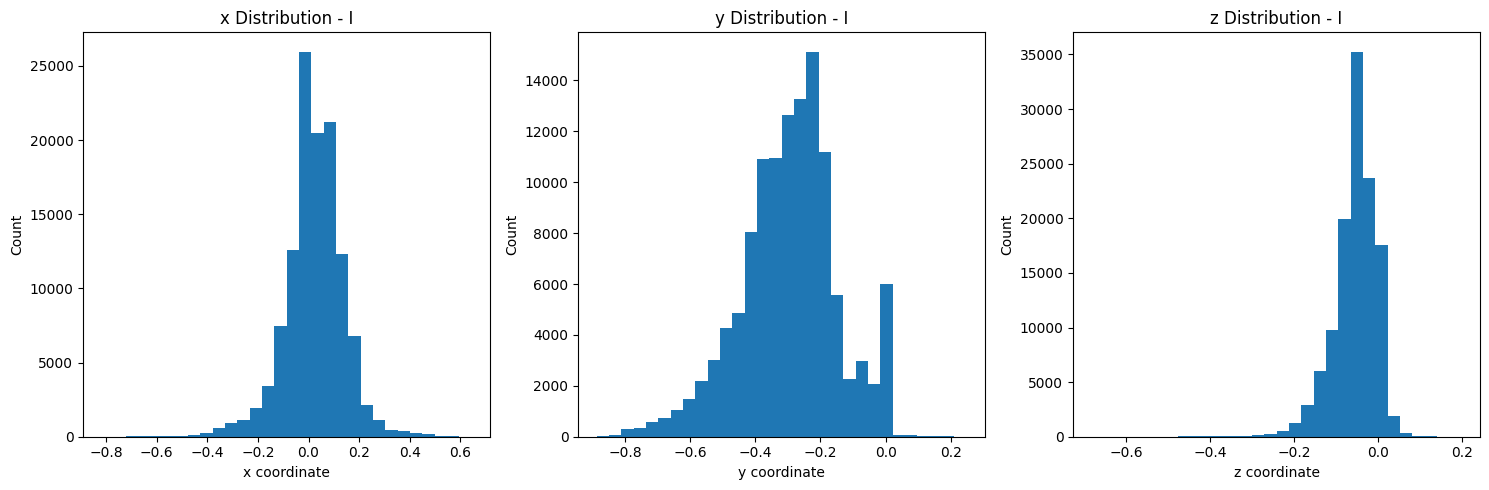


Coordinate Statistics:
                   x              y              z
count  120120.000000  120120.000000  120120.000000
mean        0.023720      -0.294923      -0.056539
std         0.116692       0.149746       0.052838
min        -0.817166      -0.887374      -0.682186
25%        -0.034157      -0.383682      -0.079363
50%         0.023828      -0.286043      -0.049215
75%         0.093882      -0.205146      -0.024206
max         0.643840       0.248386       0.198011

Gesture: J
Number of images: 5569
Number of points: 116991


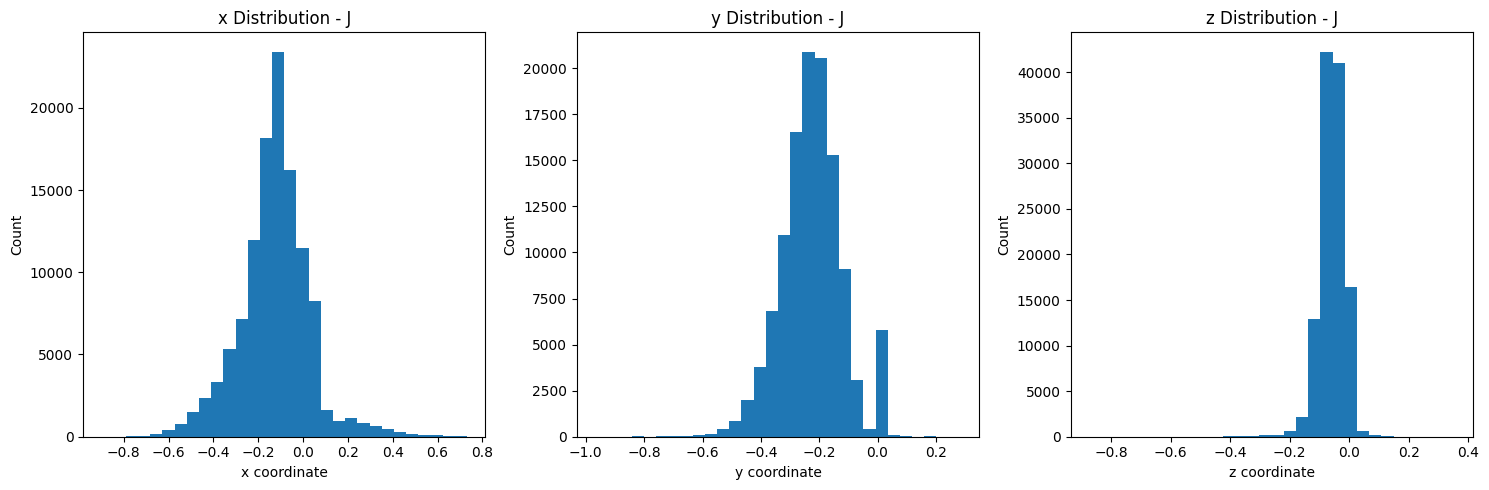


Coordinate Statistics:
                   x              y              z
count  116991.000000  116991.000000  116991.000000
mean       -0.126942      -0.225404      -0.057756
std         0.159063       0.103620       0.043569
min        -0.899916      -0.968102      -0.875042
25%        -0.208093      -0.288552      -0.080849
50%        -0.121706      -0.223575      -0.056142
75%        -0.046512      -0.163290      -0.031004
max         0.731774       0.285568       0.353376

Gesture: K
Number of images: 6714
Number of points: 141120


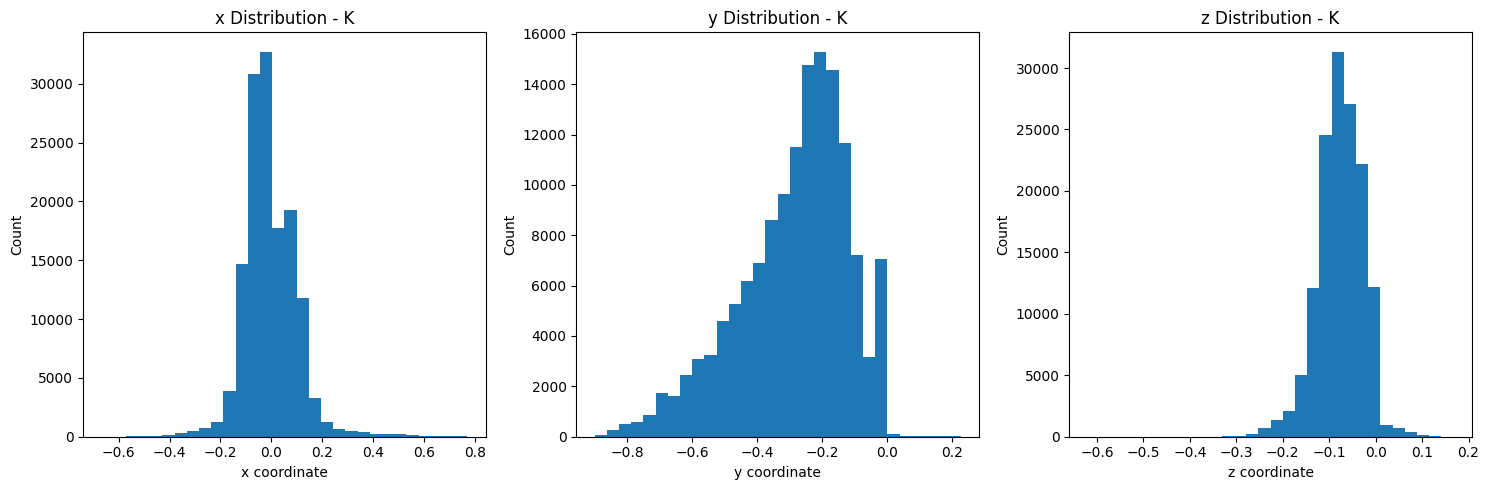


Coordinate Statistics:
                   x              y              z
count  141120.000000  141120.000000  141120.000000
mean       -0.005164      -0.285123      -0.075386
std         0.104907       0.170624       0.049716
min        -0.667003      -0.899340      -0.620041
25%        -0.069967      -0.385622      -0.104752
50%        -0.014276      -0.253742      -0.074233
75%         0.056498      -0.167389      -0.040908
max         0.768980       0.225003       0.167854

Gesture: L
Number of images: 6591
Number of points: 138684


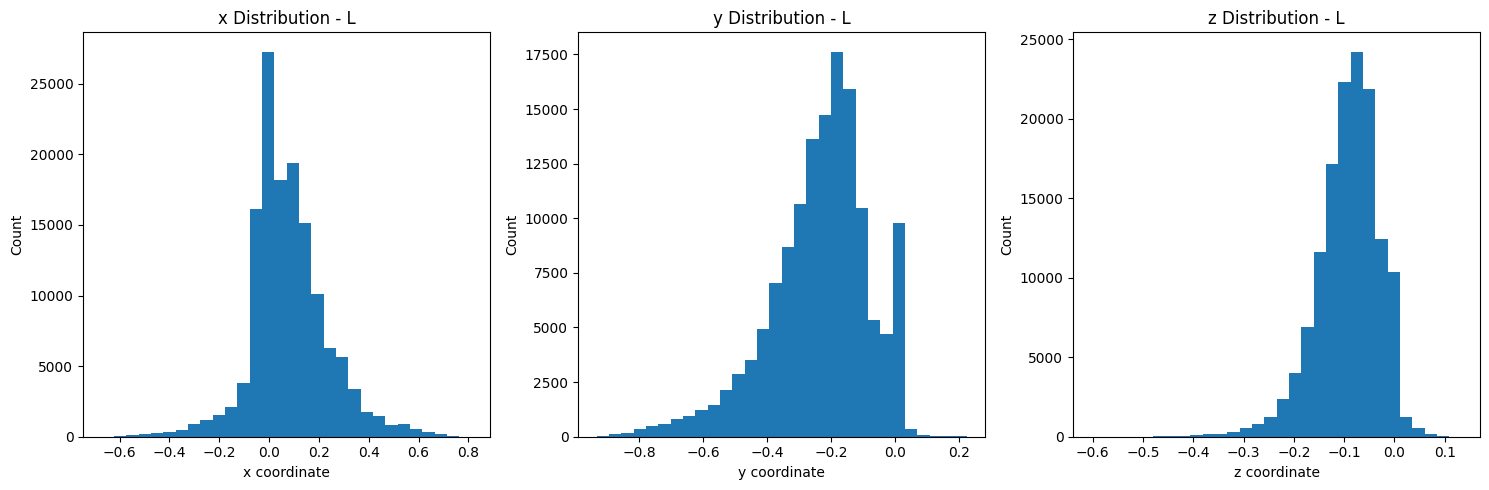


Coordinate Statistics:
                   x              y              z
count  138684.000000  138684.000000  138684.000000
mean        0.079180      -0.234857      -0.092060
std         0.156277       0.157350       0.062333
min        -0.671928      -0.932228      -0.601786
25%        -0.007640      -0.318814      -0.126148
50%         0.060762      -0.212028      -0.085744
75%         0.159189      -0.133535      -0.049647
max         0.812622       0.223590       0.133173

Gesture: M
Number of images: 3729
Number of points: 78477


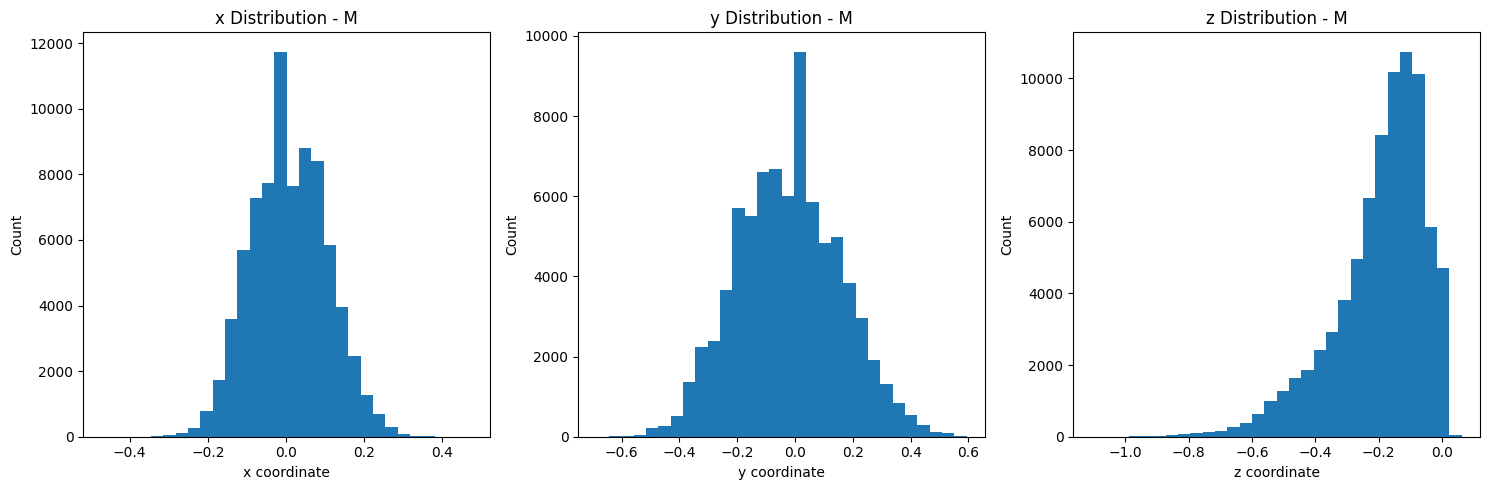


Coordinate Statistics:
                  x             y             z
count  78477.000000  78477.000000  78477.000000
mean       0.008852     -0.022508     -0.195080
std        0.096776      0.178693      0.146008
min       -0.471792     -0.686283     -1.106184
25%       -0.061260     -0.149676     -0.265168
50%        0.002242     -0.019731     -0.162446
75%        0.075751      0.099571     -0.089903
max        0.474338      0.593164      0.061387

Gesture: N
Number of images: 3058
Number of points: 64827


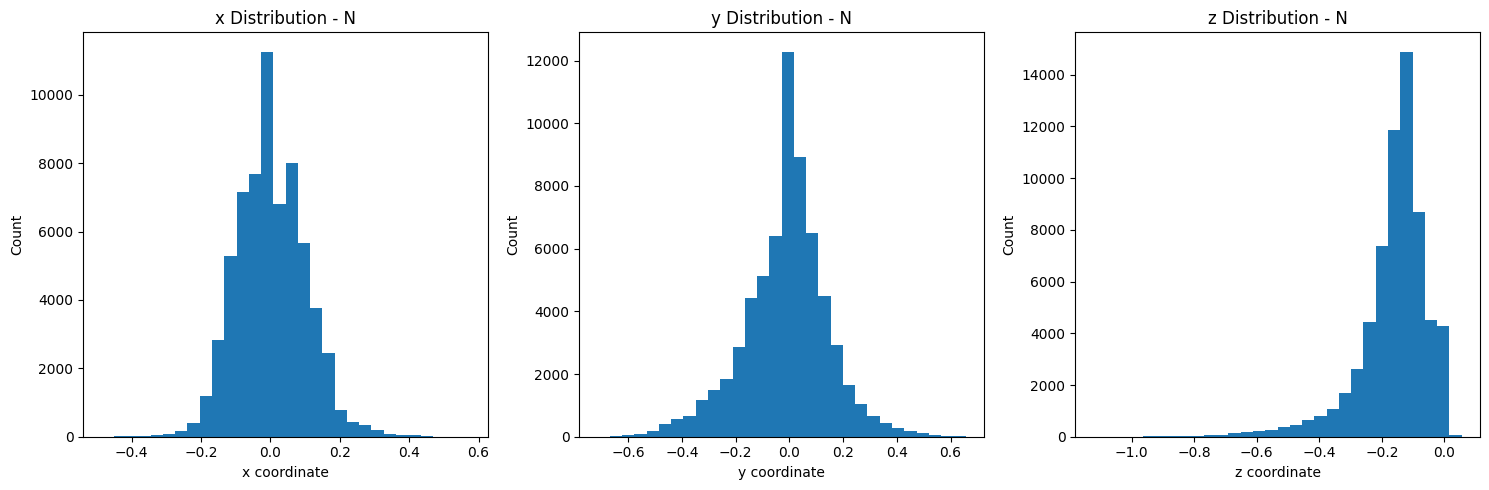


Coordinate Statistics:
                  x             y             z
count  64827.000000  64827.000000  64827.000000
mean       0.002958     -0.013137     -0.161586
std        0.099394      0.156683      0.113338
min       -0.486451     -0.714051     -1.121443
25%       -0.066698     -0.096605     -0.200683
50%        0.000000      0.000000     -0.141026
75%        0.069359      0.075239     -0.098303
max        0.574346      0.655869      0.054936

Gesture: nothing
Number of images: 3
Number of points: 63


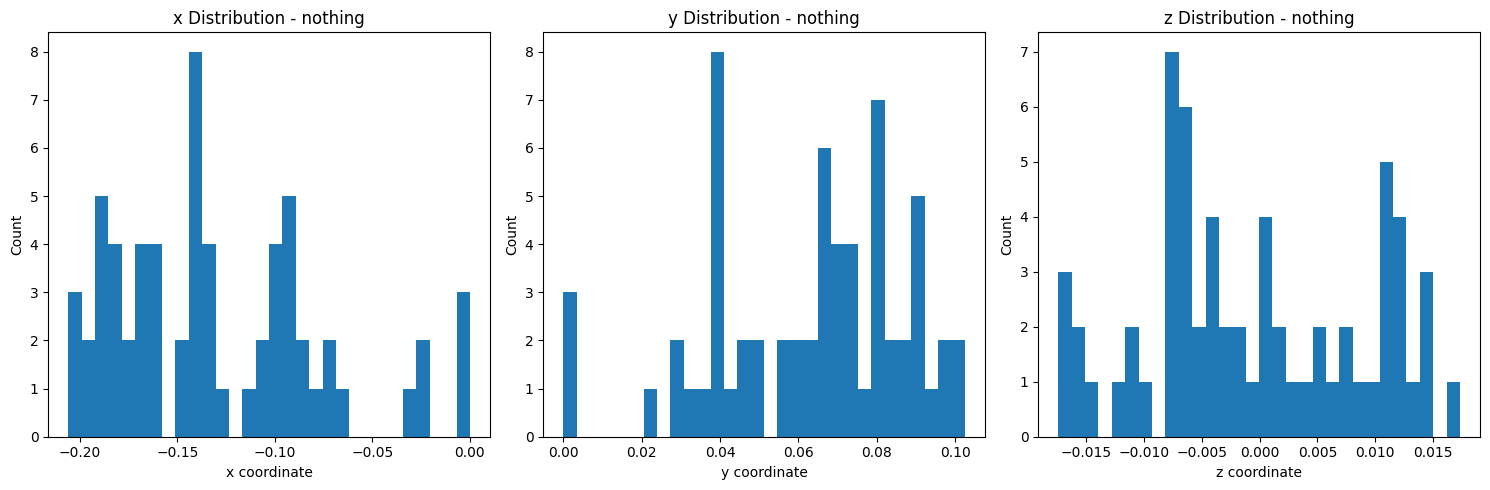


Coordinate Statistics:
               x          y          z
count  63.000000  63.000000  63.000000
mean   -0.129646   0.062822  -0.000538
std     0.053939   0.025004   0.009425
min    -0.205900   0.000000  -0.017415
25%    -0.171380   0.042025  -0.007387
50%    -0.139329   0.066966  -0.001564
75%    -0.095655   0.081766   0.007884
max     0.000000   0.102472   0.017327

Gesture: O
Number of images: 5320
Number of points: 111909


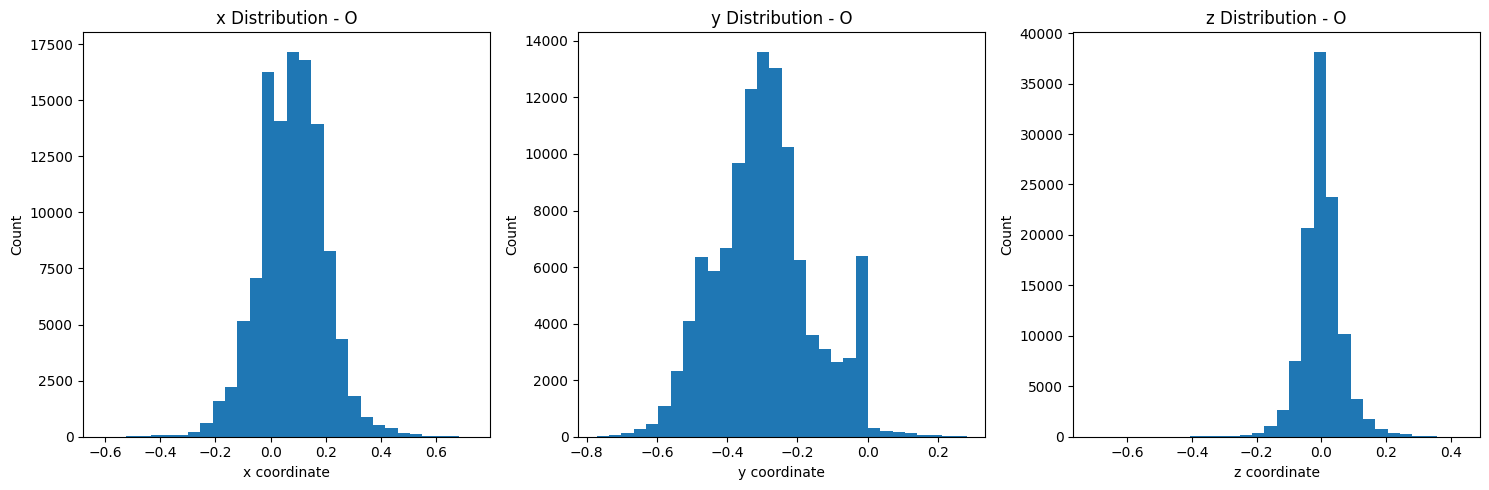


Coordinate Statistics:
                   x              y              z
count  111909.000000  111909.000000  111909.000000
mean        0.077507      -0.292831       0.001083
std         0.117443       0.141451       0.062150
min        -0.611963      -0.771776      -0.709198
25%         0.000000      -0.382707      -0.031012
50%         0.081823      -0.298145       0.000000
75%         0.153556      -0.219369       0.031369
max         0.726802       0.281201       0.432095

Gesture: P
Number of images: 4688
Number of points: 98448


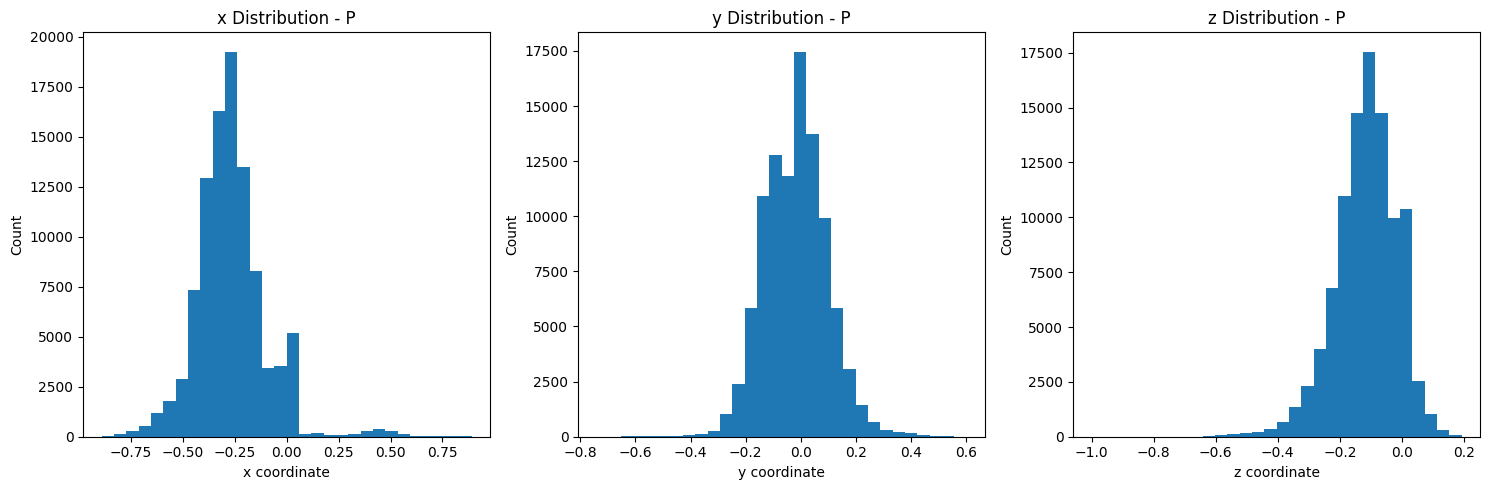


Coordinate Statistics:
                  x             y             z
count  98448.000000  98448.000000  98448.000000
mean      -0.268063     -0.018816     -0.116139
std        0.170187      0.115086      0.099915
min       -0.892170     -0.740152     -0.999594
25%       -0.367332     -0.100741     -0.174201
50%       -0.280842     -0.010471     -0.109215
75%       -0.190884      0.054438     -0.047363
max        0.889887      0.600120      0.191956

Gesture: Q
Number of images: 4943
Number of points: 104391


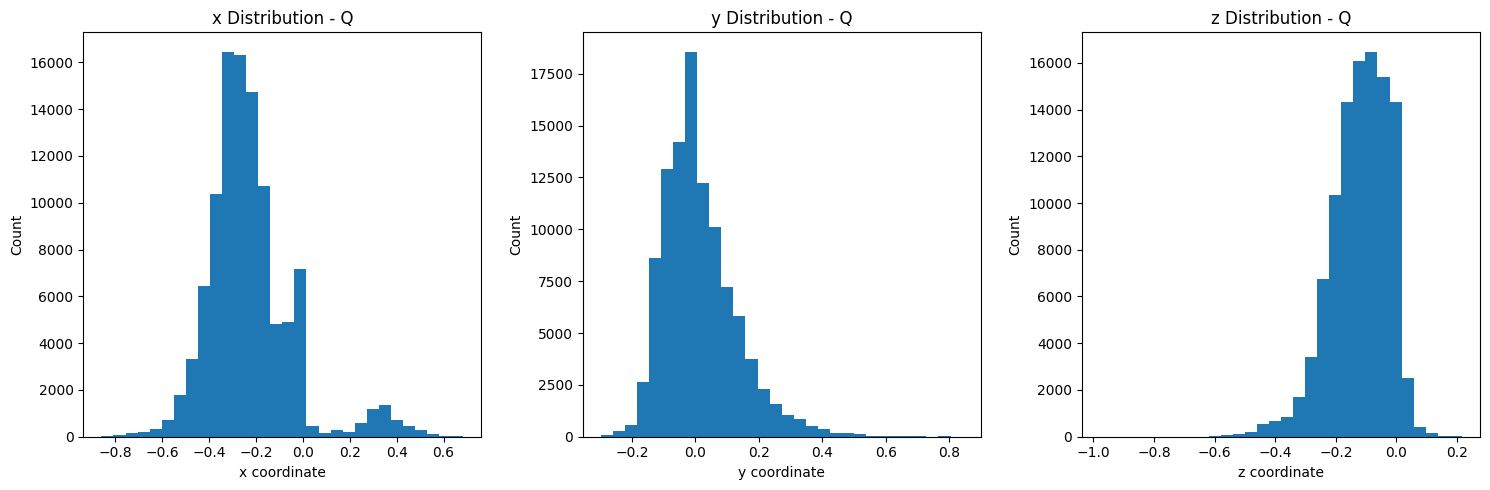


Coordinate Statistics:
                   x              y              z
count  104391.000000  104391.000000  104391.000000
mean       -0.225354       0.014429      -0.118977
std         0.185547       0.117277       0.096461
min        -0.858350      -0.298943      -0.977920
25%        -0.334777      -0.067581      -0.177334
50%        -0.253557       0.000000      -0.109752
75%        -0.159140       0.073110      -0.045617
max         0.684340       0.842457       0.215870

Gesture: R
Number of images: 6082
Number of points: 128163


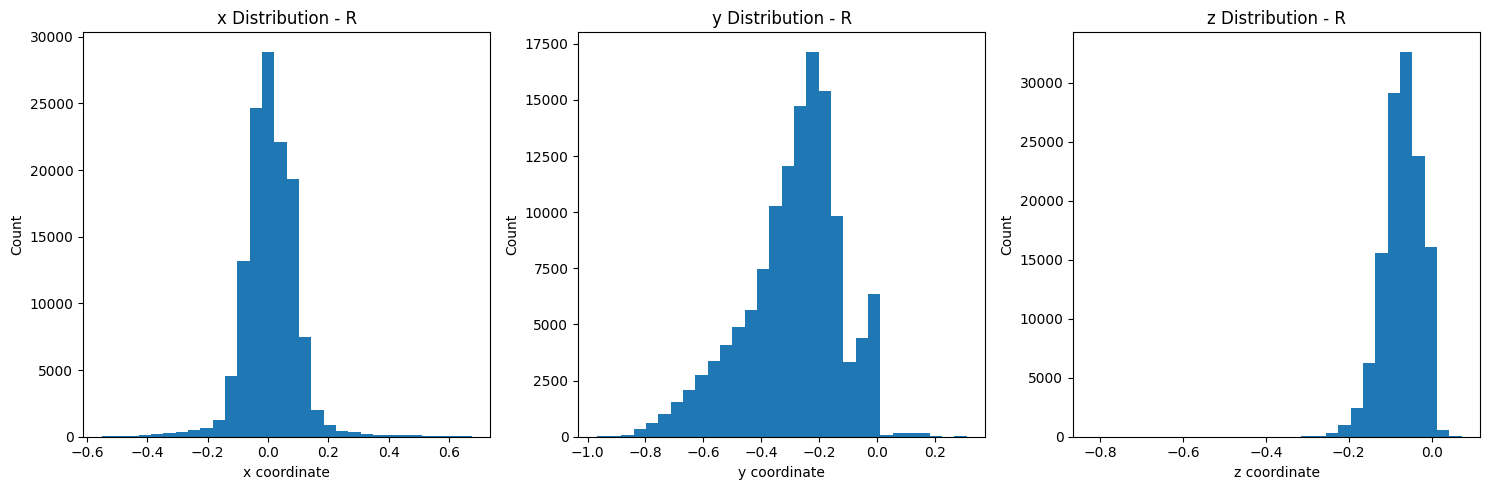


Coordinate Statistics:
                   x              y              z
count  128163.000000  128163.000000  128163.000000
mean        0.007931      -0.290654      -0.071079
std         0.087370       0.169071       0.047029
min        -0.551205      -0.968592      -0.819984
25%        -0.041273      -0.382582      -0.098470
50%         0.000000      -0.265022      -0.069004
75%         0.060422      -0.182870      -0.037402
max         0.674942       0.308225       0.071813

Gesture: S
Number of images: 5682
Number of points: 119322


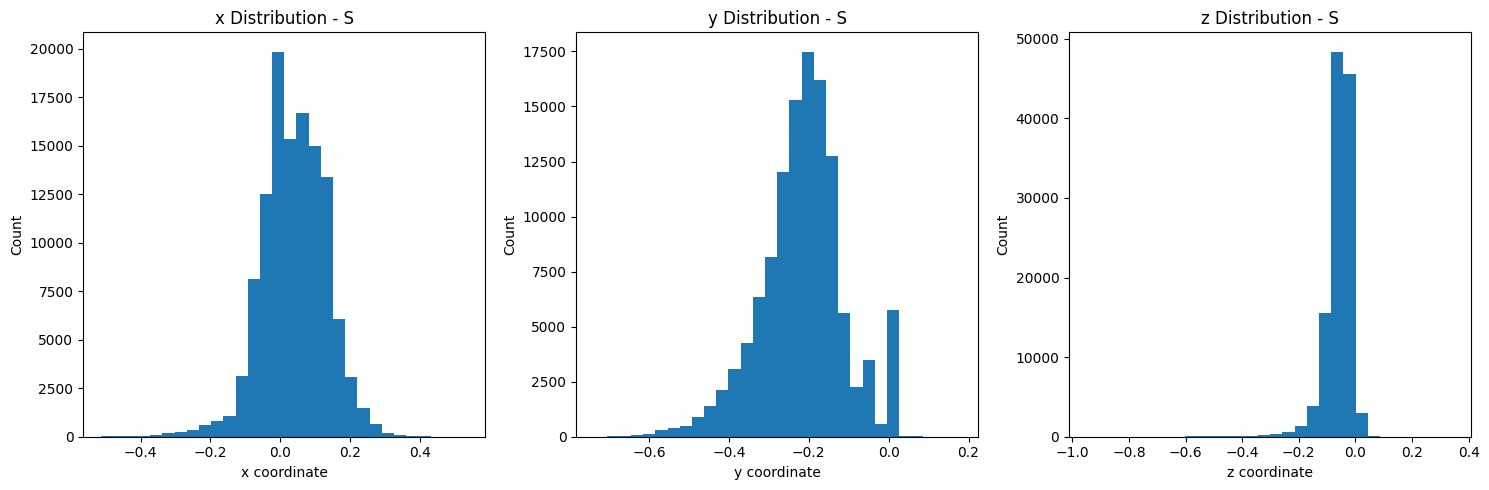


Coordinate Statistics:
                   x              y              z
count  119322.000000  119322.000000  119322.000000
mean        0.039509      -0.216115      -0.057524
std         0.092649       0.104610       0.051358
min        -0.512012      -0.736558      -0.946614
25%        -0.016936      -0.272934      -0.076724
50%         0.039246      -0.209660      -0.051165
75%         0.104650      -0.155455      -0.027358
max         0.534144       0.178820       0.344771

Gesture: space
Number of images: 3474
Number of points: 75159


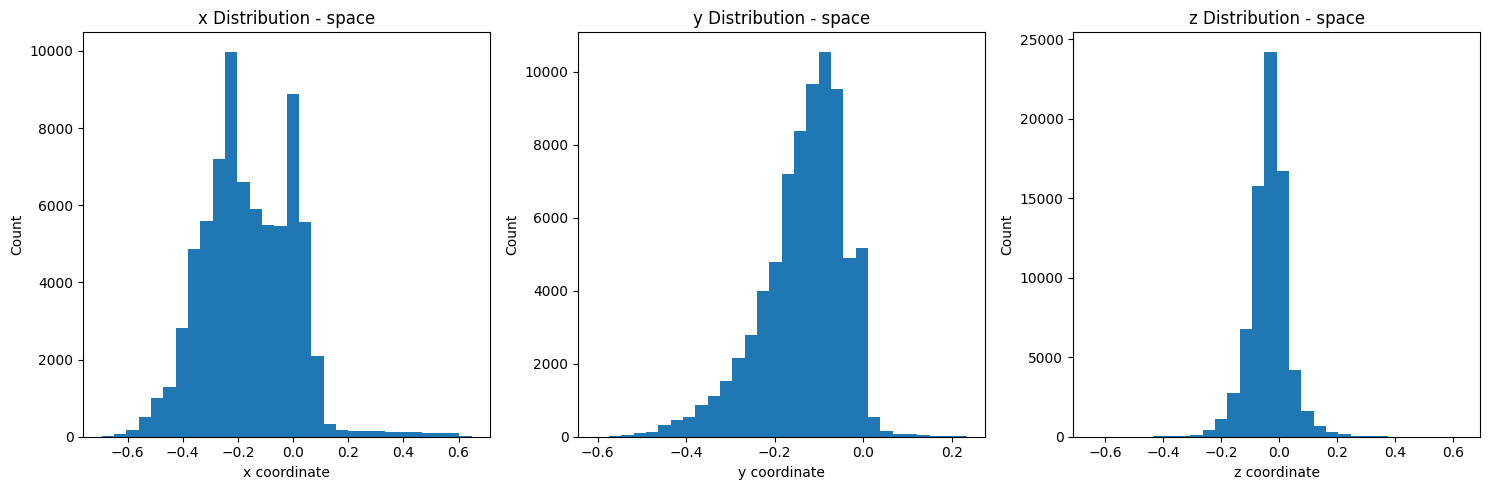


Coordinate Statistics:
                  x             y             z
count  75159.000000  75159.000000  75159.000000
mean      -0.161285     -0.135480     -0.035057
std        0.164951      0.095726      0.066707
min       -0.693838     -0.601933     -0.645722
25%       -0.273987     -0.184930     -0.068699
50%       -0.176944     -0.119591     -0.031844
75%       -0.028767     -0.068798      0.000000
max        0.647075      0.232628      0.630540

Gesture: T
Number of images: 5452
Number of points: 114492


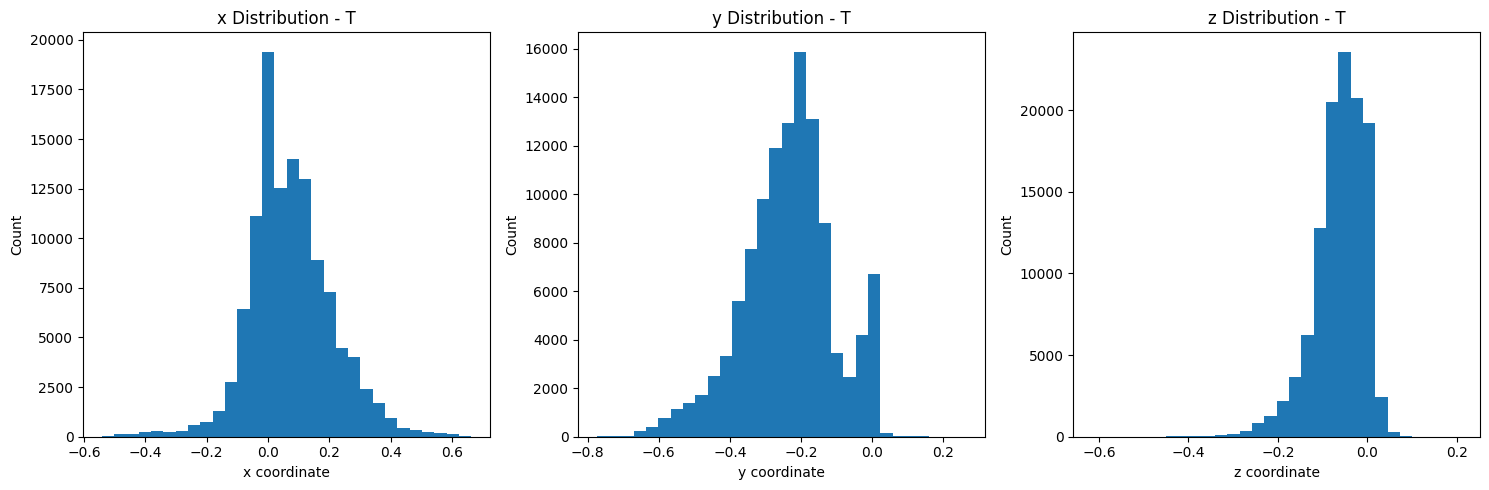


Coordinate Statistics:
                   x              y              z
count  114492.000000  114492.000000  114492.000000
mean        0.073701      -0.234145      -0.061675
std         0.136187       0.128560       0.057215
min        -0.542585      -0.774558      -0.616335
25%        -0.009617      -0.310328      -0.091175
50%         0.063067      -0.225255      -0.053893
75%         0.151235      -0.158094      -0.018872
max         0.663321       0.265752       0.210618

Gesture: U
Number of images: 6043
Number of points: 126903


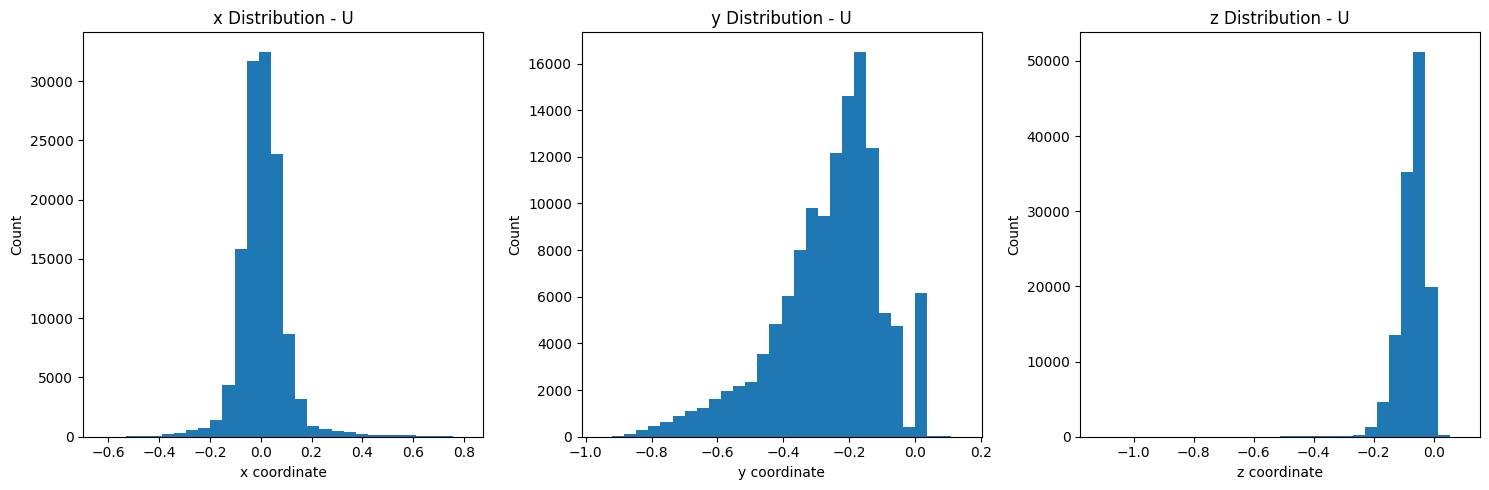


Coordinate Statistics:
                   x              y              z
count  126903.000000  126903.000000  126903.000000
mean        0.007510      -0.262578      -0.069182
std         0.094193       0.162063       0.051401
min        -0.627496      -0.956856      -1.117762
25%        -0.042153      -0.346368      -0.090455
50%         0.000000      -0.230012      -0.062187
75%         0.053153      -0.153470      -0.038602
max         0.803648       0.146443       0.093655

Gesture: V
Number of images: 6119
Number of points: 128499


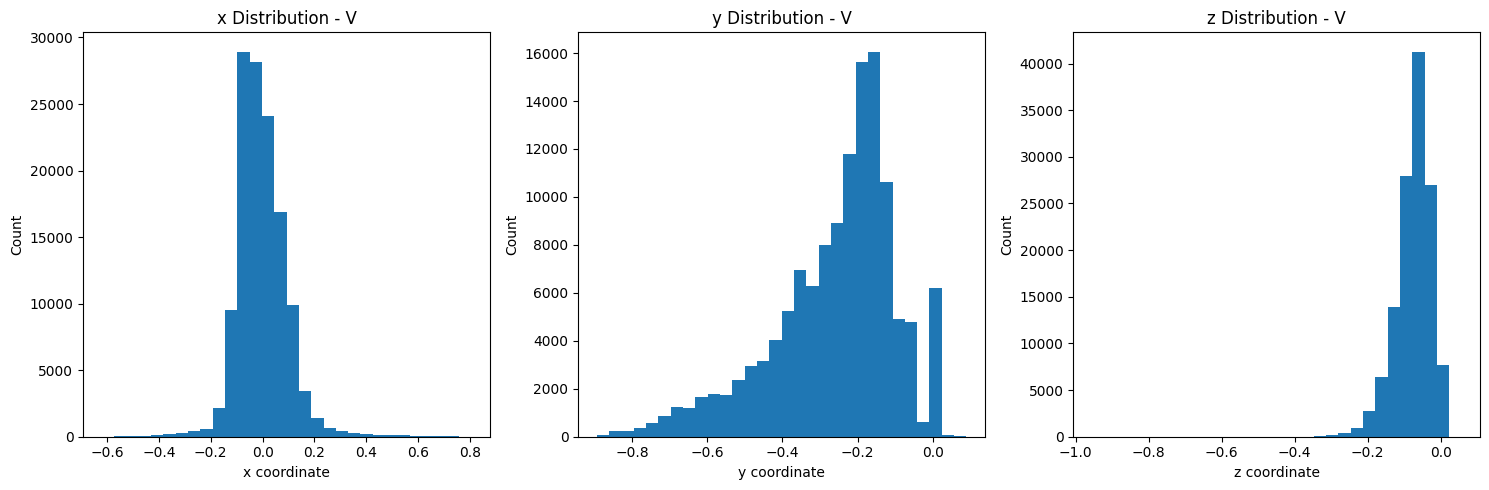


Coordinate Statistics:
                   x              y              z
count  128499.000000  128499.000000  128499.000000
mean       -0.004195      -0.259547      -0.074836
std         0.097808       0.164563       0.048341
min        -0.620869      -0.894623      -0.956221
25%        -0.065139      -0.347802      -0.099147
50%        -0.014979      -0.219143      -0.067922
75%         0.049422      -0.149731      -0.041595
max         0.805544       0.090139       0.057387

Gesture: W
Number of images: 6074
Number of points: 127554


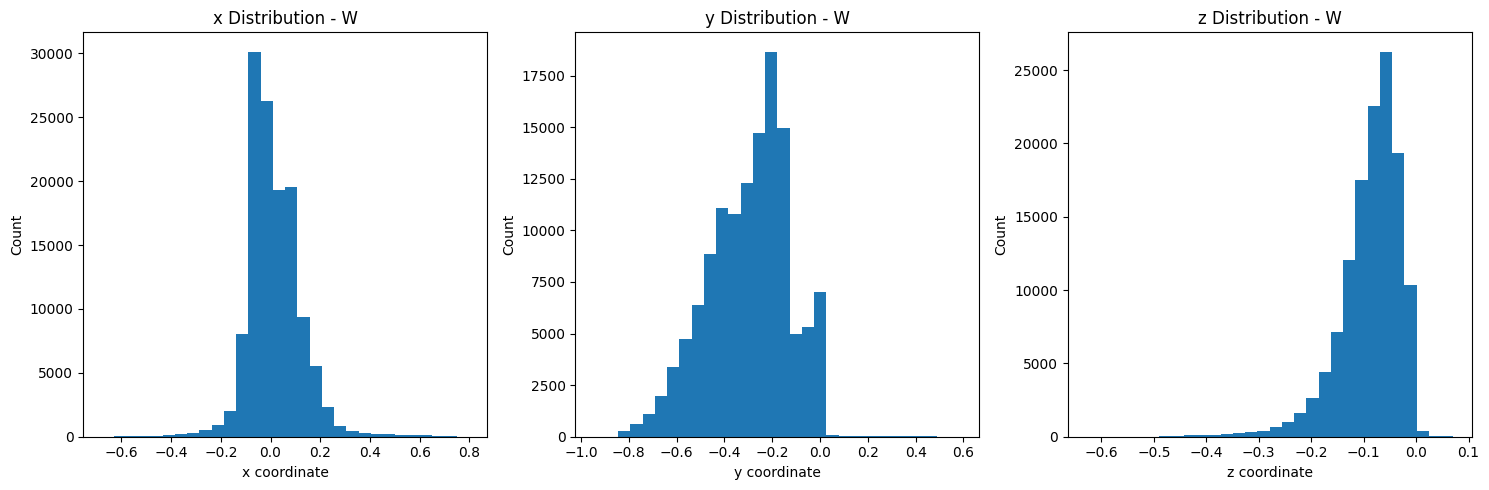


Coordinate Statistics:
                   x              y              z
count  127554.000000  127554.000000  127554.000000
mean        0.015380      -0.294788      -0.086767
std         0.108534       0.171703       0.059571
min        -0.679843      -0.946295      -0.629335
25%        -0.055630      -0.412904      -0.114521
50%         0.000000      -0.271725      -0.076247
75%         0.073651      -0.175829      -0.047344
max         0.797581       0.590011       0.070930

Gesture: X
Number of images: 5328
Number of points: 111888


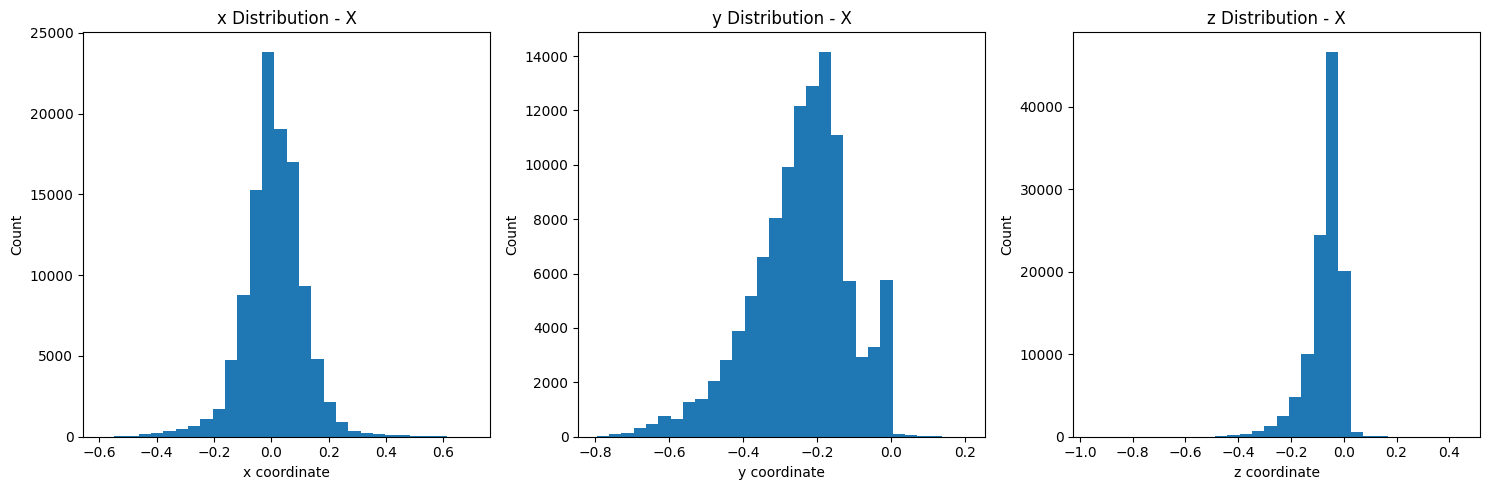


Coordinate Statistics:
                   x              y              z
count  111888.000000  111888.000000  111888.000000
mean        0.009511      -0.244122      -0.070487
std         0.104959       0.133384       0.067348
min        -0.592277      -0.796412      -0.955489
25%        -0.048016      -0.319611      -0.092978
50%         0.006935      -0.229194      -0.054131
75%         0.069886      -0.159767      -0.029299
max         0.698884       0.203997       0.446273

Gesture: Y
Number of images: 5955
Number of points: 125055


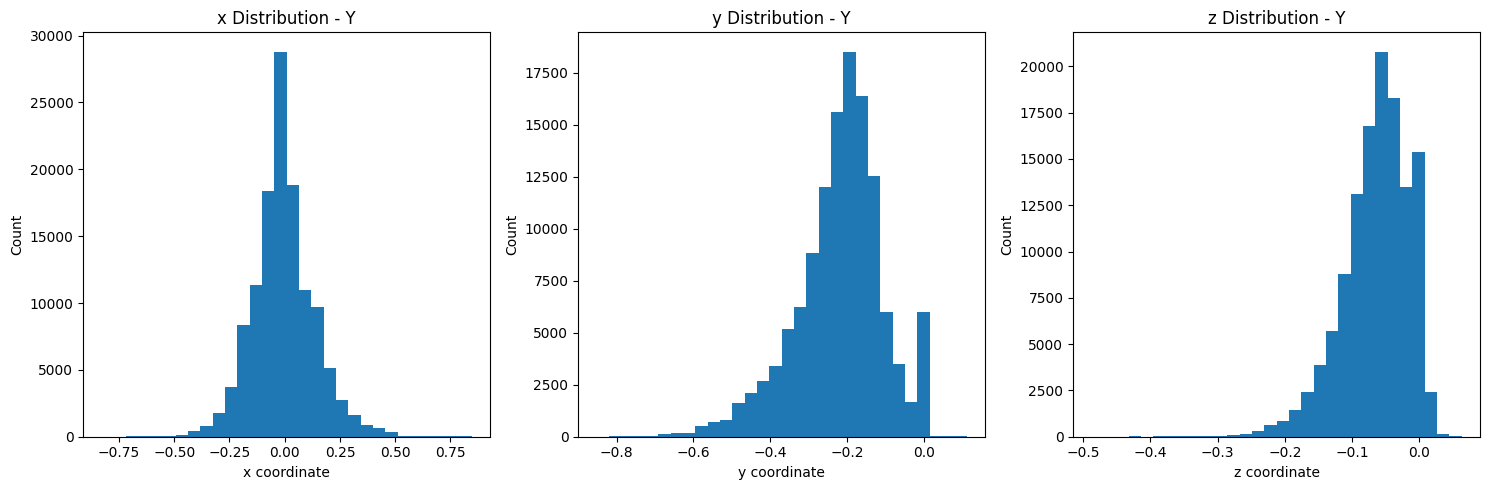


Coordinate Statistics:
                   x              y              z
count  125055.000000  125055.000000  125055.000000
mean       -0.004915      -0.219571      -0.064634
std         0.141916       0.116054       0.050843
min        -0.828415      -0.851871      -0.487599
25%        -0.085970      -0.278235      -0.091566
50%        -0.005370      -0.205807      -0.058144
75%         0.068303      -0.148461      -0.028461
max         0.845394       0.111401       0.063157

Gesture: Z
Number of images: 5393
Number of points: 113274


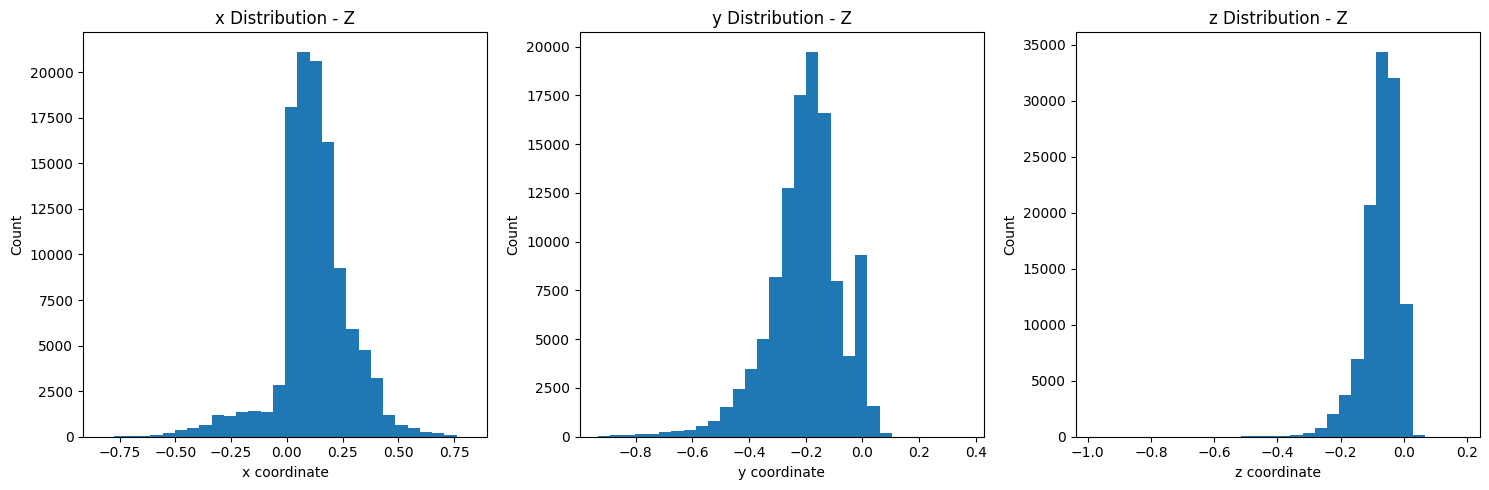


Coordinate Statistics:
                   x              y              z
count  113274.000000  113274.000000  113274.000000
mean        0.122432      -0.202238      -0.071517
std         0.161568       0.129299       0.056915
min        -0.831442      -0.933725      -0.978995
25%         0.044553      -0.266151      -0.097078
50%         0.118992      -0.192959      -0.061752
75%         0.202094      -0.127533      -0.034182
max         0.816009       0.362712       0.183039

Combined Dataset Analysis:


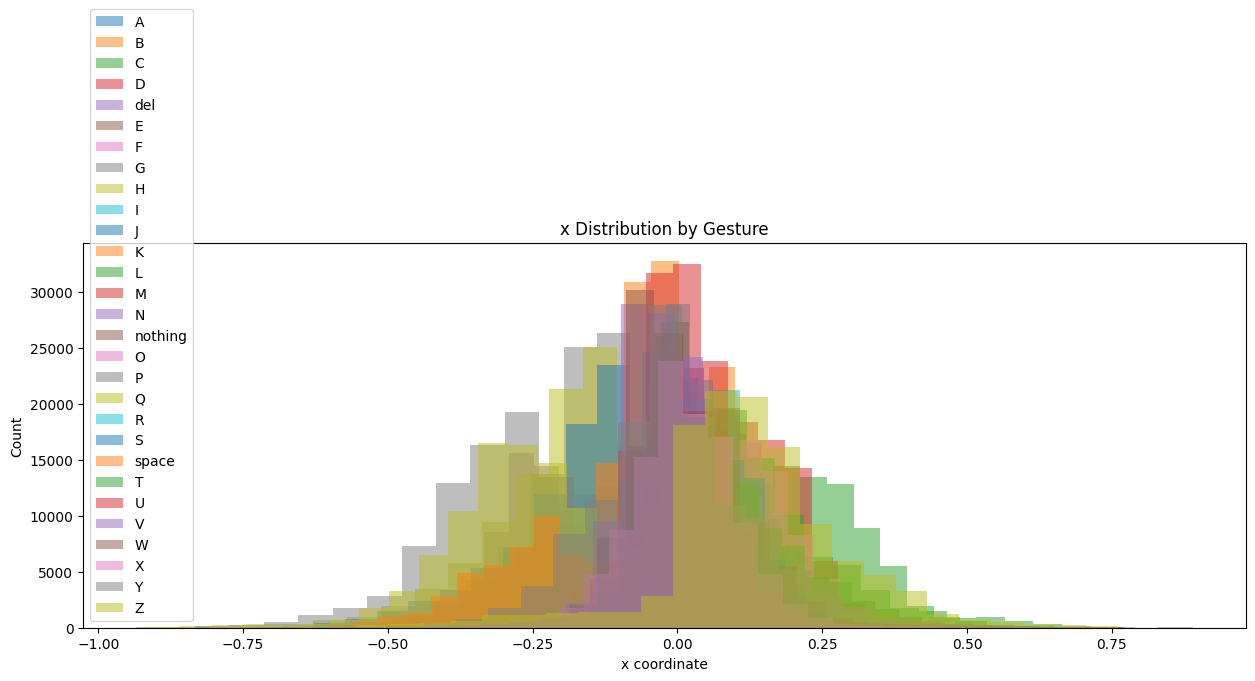

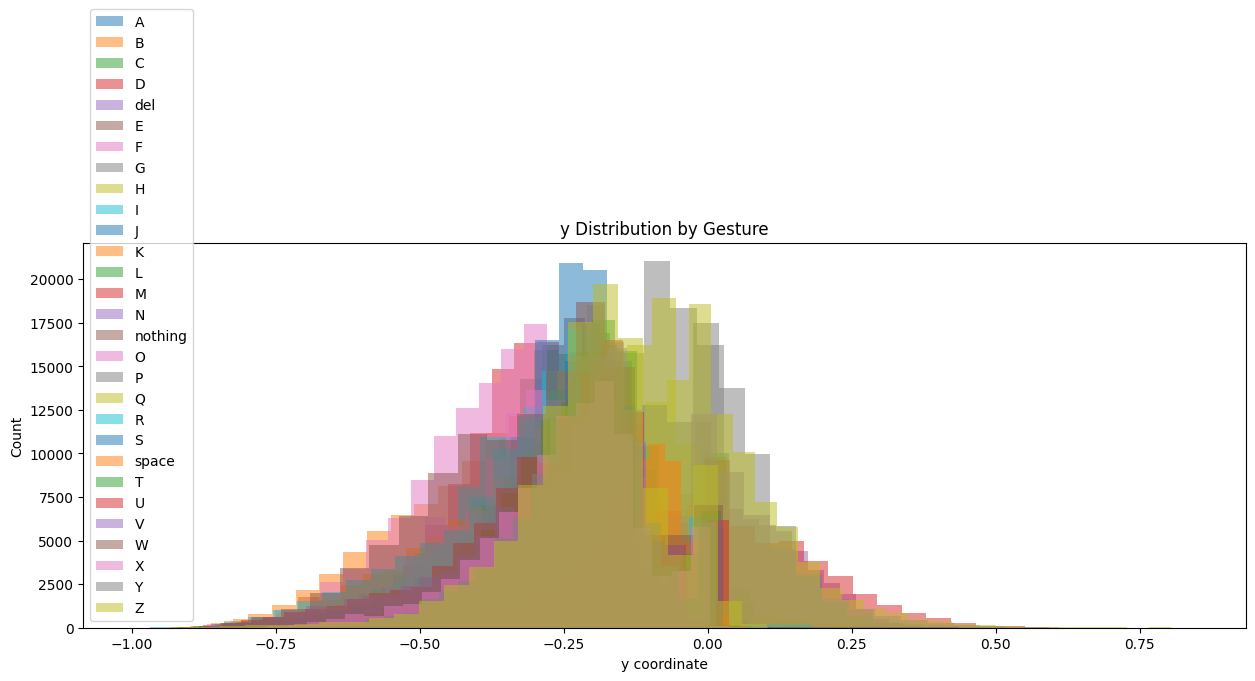

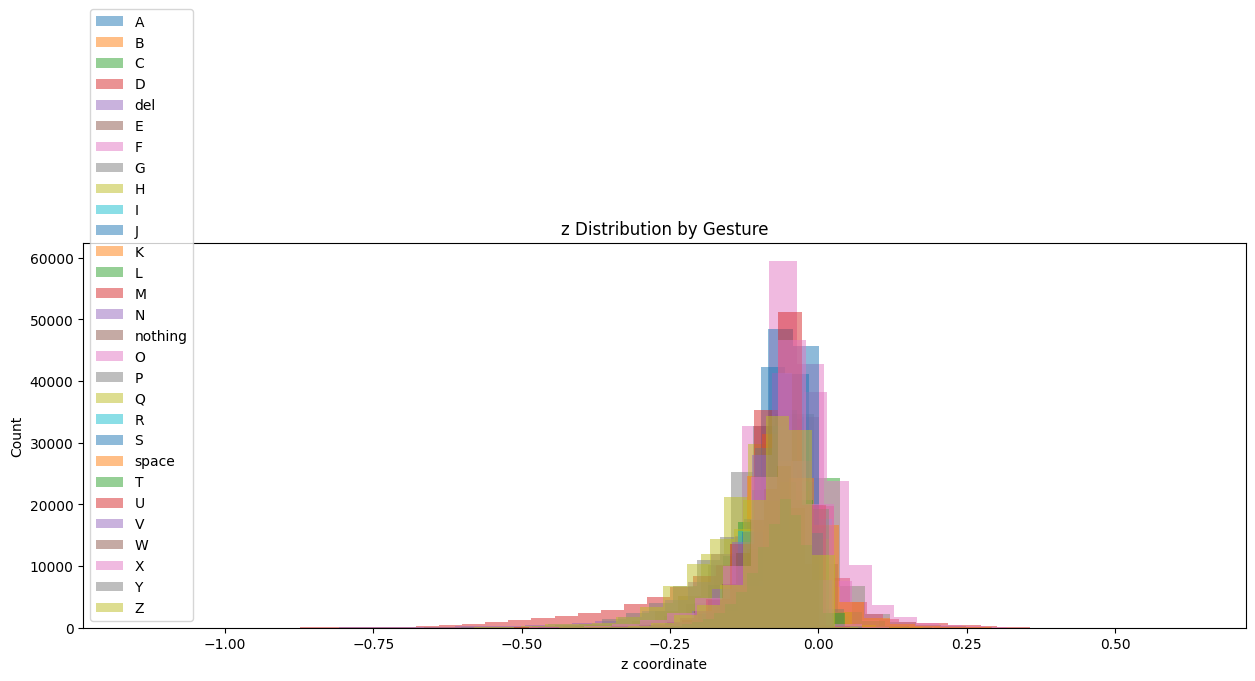

In [20]:
gesture_data, combined_df = process_folder("ASL_Alphabet_Dataset/asl_alphabet_train" , "ASL_Alphabet_Dataset/asl_alphabet_train/output_coordinates")
if gesture_data:
    analyze_coordinates(gesture_data, combined_df)